In [7]:
import os, sys
import numpy as np
from astropy import units
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import minimize
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks

from utils import *

%load_ext autoreload
%autoreload 2
from cos_flares import FlaresWithCOS

plt.rcParams['font.size'] = 18
wavelength, flux, err = load_binned_data()
times = np.load('times.npy')
orbits = np.load('orbits.npy')

wavelength = np.full(flux.shape, wavelength)

parula = np.load('/Users/arcticfox/parula_colors.npy')#[np.linspace(0,210,len(times),dtype=int)]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fwc = FlaresWithCOS(wavelength=wavelength, flux=flux,
                    flux_err=err, time=times, orbit=orbits)
fwc.load_line_table(path='/Users/arcticfox/Documents/AUMic/')

In [3]:
fwc.measure_FUV130()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later


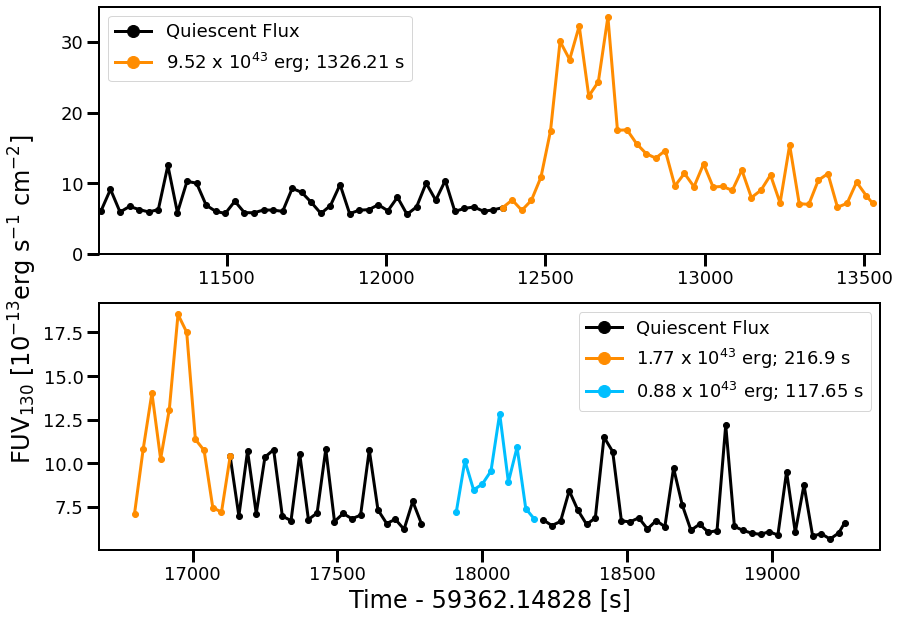

In [78]:
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14,10))
fig.set_facecolor('w')

distance = (9.79 * units.pc).to(units.cm)

q = ((fwc.orbit == 2) & (fwc.time.value<=12370))
f = ((fwc.orbit == 2) & (fwc.time.value>=12350))
energy, duration = fwc.measure_flare_params(q, f, distance)
label = str(np.round(energy.value/10**43,2)) + ' x 10$^{43}$ erg; '+ str(np.round(duration.value, 2)) + ' s'
ax1.plot(fwc.time[q], fwc.fuv130[q]/10**-13, 'k', lw=3,
         label='Quiescent Flux', marker='o')
ax1.plot(fwc.time[f], fwc.fuv130[f]/10**-13, 'darkorange', lw=3, label=label, marker='o')
ax1.set_ylim(0,35)
ax1.set_xlim(11100,13550)
ax1.legend()


q = ((fwc.orbit == 3) & (fwc.time.value>=17120) & (fwc.time.value<=17800.943))
f = ((fwc.orbit == 3) & (fwc.time.value<=17140))
energy, duration = fwc.measure_flare_params(q, f, distance)
label = str(np.round(energy.value/10**43,2)) + ' x 10$^{43}$ erg; '+ str(np.round(duration.value, 2)) + ' s'

ax2.plot(fwc.time[q], fwc.fuv130[q]/10**-13, 'k', lw=3,
         label='Quiescent Flux', marker='o')
ax2.plot(fwc.time[f], fwc.fuv130[f]/10**-13, 'darkorange', lw=3, marker='o', label=label)



q = ((fwc.orbit == 3) & (fwc.time.value>=18200))
f = ((fwc.orbit == 3) & (fwc.time.value>=17880.943) & (fwc.time.value<=18200.943))
energy, duration = fwc.measure_flare_params(q, f, distance)
label = str(np.round(energy.value/10**43,2)) + ' x 10$^{43}$ erg; '+ str(np.round(duration.value, 2)) + ' s'

ax2.plot(fwc.time[q], fwc.fuv130[q]/10**-13, 'k', lw=3, marker='o')
ax2.plot(fwc.time[f], fwc.fuv130[f]/10**-13,'deepskyblue', marker='o', lw=3, label=label)


ax2.legend()
ax2.set_ylabel('FUV$_{130}$ [10$^{-13}$erg s$^{-1}$ cm$^{-2}$]', y=1.02, fontsize=24)
ax2.set_xlabel('Time - 59362.14828 [s]', fontsize=24)


plt.subplots_adjust(hspace=0.2)
plt.savefig('fuv130_flares.png', dpi=250, rasterize=True, bbox_inches='tight')

In [5]:
for ion in fwc.line_table['ion']:
    fwc.measure_ew(ion)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later


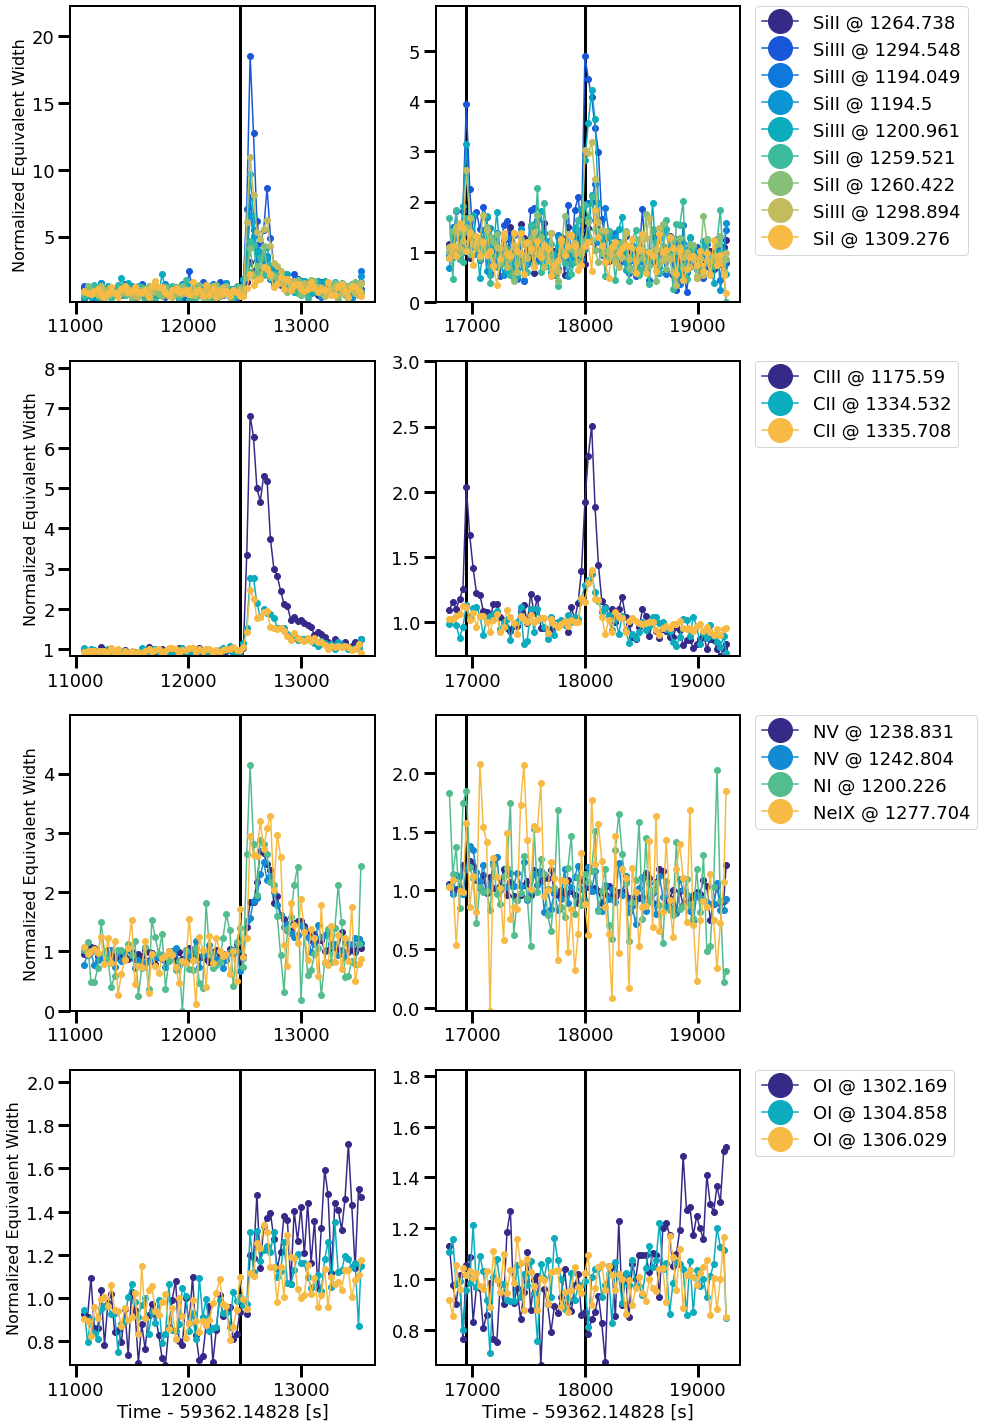

In [8]:
mask1 = fwc.orbit == 2
mask2 = fwc.orbit == 3

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(12,25))
fig.set_facecolor('w')
lw=3

i = 0
x = 0
for ax in axes.reshape(-1):
    if i < 2:
        names = [i for i in fwc.width_table.colnames if 'Si' in i]
    elif i >=2 and i < 4:
        names = [i for i in fwc.width_table.colnames if 'C' in i]
    elif i >=4 and i < 6:
        names = [i for i in fwc.width_table.colnames if 'N' in i]
    elif i >=6 and i < 8:
        names = [i for i in fwc.width_table.colnames if 'O' in i]
        
    pc = parula[np.linspace(0,210,len(names),dtype=int)]
    mins, maxes = np.zeros(len(names)), np.zeros(len(names))
    
    for n,name in enumerate(names):
        if x == 0:
            ax.errorbar(fwc.time[mask1].value, 
                        fwc.width_table[name][mask1]/np.nanmedian(fwc.width_table[name][mask1]),
                        #fwc.error_table[name][mask1]/np.nanmedian(fwc.error_table[name][mask1])/1.5,
                        color=pc[n],marker='o', linestyle='-')
            ax.vlines(12455.942687932402, -5,30, 'k', lw=lw)
            mins[n] = np.nanmin(fwc.width_table[name][mask1]/np.nanmedian(fwc.width_table[name][mask1]))
            maxes[n] = np.nanmax(fwc.width_table[name][mask1]/np.nanmedian(fwc.width_table[name][mask1]))
            ax.set_ylabel('Normalized Equivalent Width', fontsize=16)
        else:
            ax.errorbar(fwc.time[mask2].value, 
                        fwc.width_table[name][mask2]/np.nanmedian(fwc.width_table[name][mask2]),
                        #fwc.error_table[name][mask2]/np.nanmedian(fwc.error_table[name][mask2])/1.5,
                        color=pc[n], marker='o', linestyle='-',
                        label='{} @ {}'.format(name.split('_')[0],
                                              np.round(fwc.line_table[fwc.line_table['ion']==name]['wave_c'][0], 3))
                       )
            ax.vlines(16949.943, -5,30, 'k', lw=lw)
            ax.vlines(17999.943, -5,30, 'k', lw=lw)
            mins[n] = np.nanmin(fwc.width_table[name][mask2]/np.nanmedian(fwc.width_table[name][mask2]))
            maxes[n] = np.nanmax(fwc.width_table[name][mask2]/np.nanmedian(fwc.width_table[name][mask2]))
    ax.set_ylim(np.nanmin(mins), np.nanmax(maxes)+np.nanmax(maxes)/5)
    ax.set_rasterized(True)
    if x == 1:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,
                  markerscale=4)
    x += 1
    if x == 2:
        x = 0
        
    if i >5:
        ax.set_xlabel('Time - 59362.14828 [s]')
    i += 1
plt.savefig('new_lines.png', rasterize=True, bbox_inches='tight', dpi=250)

In [46]:
fwc.time[mask2].value

array([16799.94268761, 16829.94268761, 16859.94268761, 16889.94268761,
       16919.94268761, 16949.94268761, 16979.94268761, 17009.94268761,
       17039.94268761, 17069.94268761, 17099.94268761, 17129.94268761,
       17159.94268761, 17189.94268761, 17219.94268761, 17249.94268761,
       17279.94268761, 17309.94268761, 17339.94268761, 17369.94268761,
       17399.94268761, 17429.94268761, 17459.94268761, 17489.94268761,
       17519.94268761, 17549.94268761, 17579.94268761, 17609.94268761,
       17639.94268761, 17669.94268761, 17699.94268761, 17729.94268761,
       17759.94268761, 17789.94268761, 17819.94268761, 17849.94268761,
       17879.94268761, 17909.94268761, 17939.94268761, 17969.94268761,
       17999.94268761, 18029.94268761, 18059.94268761, 18089.94268761,
       18119.94268761, 18149.94268761, 18179.94268761, 18209.94268761,
       18239.94268761, 18269.94268761, 18299.94268761, 18329.94268761,
       18359.94268761, 18389.94268761, 18419.94268761, 18449.94268761,
      